
## "*BOOST A MOVE*" - Exploring boosting for Regression

#### Ethan Conrad
#### Department of Geological Sciences, Jackson School of Geosciences
#### UT - Institute for Geophysics, Jackson School of Geoscience

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Misael Morales, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/misaelmmorales/)


### Executive Summary

Boosting is commonly used for many machine learning (ML) problems, including classification and regression. However, many users do not fully understand the parameters that control the various boosting algorithms, and the approach becomes a black box. This workflow has two main objectives. First, it provides an interactive demonstration of two boosting methods, gradient and adaptive boosting (AdaBoost), so that users can plug in their own datasets and explore how predictions may change with modified hyperparameters. Second, it allows users to investigate boosting hyperparameters and their importance in model predictions. From this workflow, we learn the relative importance of the main boosting parameters (number of estimators, number of leaf nodes, learning rate) and the differences between gradient and adaptive boosting (AdaBoost) methods. From this, we learn that, like many machine learning methods, the user should understand how the model works “under the hood” and thus choose and tailor the model to fit the problem. In the case of boosting, we learn that AdaBoosting is more customizable. However, gradient boosting is more flexible and, in many cases, will produce better predictions.  

### Import packages

In [1]:
import math                                               # simple calculations
from sklearn import tree                                  # tree program from scikit learn (package for machine learning)
from sklearn.tree import _tree                            # gather information about trees
from sklearn import metrics                               # Ways to evaluate and check our models
import pandas as pd                                       # DataFrames and plotting
import pandas.plotting as pd_plot
import numpy as np                                        # arrays and matrix math
import matplotlib.pyplot as plt                           # plotting
from sklearn.ensemble import GradientBoostingRegressor    # Method 1 used in machine learning for regression problems: to be investigated here
from sklearn.ensemble import AdaBoostRegressor # Method 2 used in machine learning for regression problems: to be investigated here
from sklearn.tree import DecisionTreeRegressor # Method 3 used in machine learning for regression problems: to be investigated here as part of AdaBoosting
from sklearn.tree import ExtraTreeRegressor # # Method 4 used in machine learning for regression problems: to be briefly investigated here.
from sklearn import preprocessing # scaling, centering and binarizing models
from sklearn import utils # utilities for scikitlearn
import seaborn as sns # seaborn makes beautiful visualizations of datasets with many fun customizations.
import patchworklib as pw # this library is built on to seaborn and matplotlib to easily grid seaborn plots.
from cmcrameri import cm # Colormaps from the perceptually uniform scientific colormaps library of Fabio Crameri (https://www.fabiocrameri.ch/colourmaps/) 
from ipywidgets import interactive                      # widgets and interactivity
from ipywidgets import widgets                            
from ipywidgets import Layout
from ipywidgets import Label
from ipywidgets import VBox, HBox
from scipy.stats import norm                            # Gaussian distribution
import ipyevents # used for 3d plots
import scipy.stats as st                                # statistical methods
from mpl_toolkits.mplot3d import Axes3D # package used for 3d plots

<Figure size 100x100 with 0 Axes>

### Define function used throughout the workflow

In [2]:
def visualize_model(model,xfeature,x_min,x_max,yfeature,y_min,y_max,response,z_min,z_max,title,):# plots the data points and the decision tree prediction from Prof. Pyrcz's gradient boosting workflow (https://t.co/qzhPWHwEC0?amp=1)
    cmap = cm.lajolla
    xplot_step = (x_max - x_min)/300.0; yplot_step = (y_max - y_min)/300.0 # resolution of the model visualization
    xx, yy = np.meshgrid(np.arange(x_min, x_max, xplot_step), # set up the mesh
                     np.arange(y_min, y_max, yplot_step))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])      # predict with our trained model over the mesh
    Z = Z.reshape(xx.shape)
    plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=1, linewidths=0.3, edgecolors="black")
    im = plt.imshow(Z,interpolation = None,aspect = "auto",extent = [x_min,x_max,y_min,y_max], vmin = z_min, vmax = z_max,cmap = cmap)
    plt.title(title)                                       # add the labels
    plt.xlabel(xfeature.name + '(%)'); plt.ylabel(yfeature.name + '(%)')
    plt.xlim([x_min,x_max]); plt.ylim([y_min,y_max])
    cbar = plt.colorbar(im, orientation = 'vertical')      # add the color bar
    cbar.set_label(response.name + '(MCFPD)', rotation=270, labelpad=20)
    return Z

def check_model(model,xfeature,yfeature,response,title):    # plots the estimated vs. the actual from Prof. Pyrcz's gradient boosting workflow (https://t.co/qzhPWHwEC0?amp=1)
    predict_train = model.predict(np.c_[xfeature,yfeature])
    plt.scatter(response,predict_train,s=None, c='red',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.3, edgecolors="black")
    plt.title(title); plt.xlabel('Actual Production (MCFPD)'); plt.ylabel('Estimated Production (MCFPD)')
    plt.arrow(0,0,7000,7000,width=0.02,color='black',head_length=0.0,head_width=0.0)
    MSE = metrics.mean_squared_error(response,predict_train)
    Var_Explained = metrics.explained_variance_score(response,predict_train)
    cor = math.sqrt(metrics.r2_score(response,predict_train))
    print('Mean Squared Error on Training = ', round(MSE,2),', Variance Explained =', round(Var_Explained,2),'Cor =', round(cor,2))
    return MSE

def GradBoost_make(num_tree, max_leaf_nodes, learning_rate): # Function for gradient boosting GUI
    
    params = {                             # see workflow for parameter explainations
        'loss': 'squared_error',           # L2 Norm - least squares
        'max_leaf_nodes': max_leaf_nodes,  # maximum leaf nodes per tree
        'learning_rate': learning_rate,    # learning rate
        'criterion': 'friedman_mse'        # tree construction criteria is friedman mean squared error
    }
    
    boosting_model = GradientBoostingRegressor(n_estimators=int(num_tree),**params) # create boosting model
    boosting_model.fit(X = predictors_train.values, y = response_train.values.ravel()) # fit model
    score = (boosting_model.score(X = predictors_test.values, y = response_test.values)) # extract boosting score
    plt.subplot(121)
    visualize_model(boosting_model,Data_sub_train["Por"],PorMin,PorMax,Data_sub_train["Brittle"],BrittleMin,BrittleMax,Data_sub_train["Production"],ProdMin,ProdMax,'Training Data and Boosting with ' + str(int(num_tree)) + ' Trees') # run visualization function
    plt.subplot(122)
    MSE = check_model(boosting_model,Data_sub_test["Por"],Data_sub_test["Brittle"],Data_sub_test["Production"],'Tree-Based Boosting with ' + str(int(num_tree)) + ' Trees') # calculate MSE
    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.6, wspace=0.2, hspace=0.3)
    plt.show()
    return MSE

def ReturnGradientBoostMSE(num_tree, max_leaf_nodes, learning_rate): # Return the MSE from gradient boosting for evaluating the models iteratively
    # Set parameters - after Prof. Pyrcz's gradient boosting workflow (https://t.co/qzhPWHwEC0?amp=1)
    params = {                             # see workflow for parameter explainations
        'loss': 'squared_error',           # L2 Norm - least squares
        'max_leaf_nodes': max_leaf_nodes,  # maximum leaf nodes per tree
        'learning_rate': learning_rate,    # learning rate
        'criterion': 'friedman_mse'        # tree construction criteria is friedman mean squared error
    }
    
    boosting_model = GradientBoostingRegressor(n_estimators=int(num_tree),**params) # create boosting model
    boosting_model.fit(X = predictors_train.values, y = response_train.values.ravel()) # fit boosting model
    predict_train = boosting_model.predict(np.c_[Data_sub_test["Por"],Data_sub_test["Brittle"]]) # predict testing set
    MSE = metrics.mean_squared_error(Data_sub_test["Production"],predict_train) # calculate MSE
    return MSE

def AdaBoost_make(num_tree, max_leaf_nodes,learning_rate):  # Function for AdaBoosting GUI
    dtree = DecisionTreeRegressor(max_leaf_nodes = max_leaf_nodes, criterion = 'friedman_mse') # set up base regressor - decision tree
    boosting_model = AdaBoostRegressor(n_estimators=int(num_tree), base_estimator=dtree, learning_rate=learning_rate, loss = 'square') # create AdaBoosting model
    boosting_model.fit(X = predictors_train.values, y = response_train.values.ravel()) # fit model
    score = (boosting_model.score(X = predictors_test.values, y = response_test.values)) # score model
    plt.subplot(121)
    visualize_model(boosting_model,Data_sub_train["Por"],PorMin,PorMax,Data_sub_train["Brittle"],BrittleMin,BrittleMax,Data_sub_train["Production"],ProdMin,ProdMax,'Training Data and Boosting with ' + str(int(num_tree)) + ' Trees') # visualize results
    plt.subplot(122)
    MSE = check_model(boosting_model,Data_sub_test["Por"],Data_sub_test["Brittle"],Data_sub_test["Production"],'Tree-Based Boosting with ' + str(int(num_tree)) + ' Trees') # check model function for subplot in GUI
    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.6, wspace=0.2, hspace=0.3)
    plt.show()
    return MSE

def ReturnAdaMSE(num_tree, max_leaf_nodes,learning_rate): # Return the MSE from Adaboosting for evaluating the models iteratively 
    dtree = DecisionTreeRegressor(max_leaf_nodes = max_leaf_nodes)# set up base regressor - decision tree
    boosting_model = AdaBoostRegressor(n_estimators=int(num_tree), base_estimator=dtree, learning_rate=learning_rate) # create AdaBoosting model
    boosting_model.fit(X = predictors_train.values, y = response_train.values.ravel()) # fit model
    score = (boosting_model.score(X = predictors_test.values, y = response_test.values)) # score model
    predict_train = boosting_model.predict(np.c_[Data_sub_test["Por"],Data_sub_test["Brittle"]]) # predict testing set
    MSE = metrics.mean_squared_error(Data_sub_test["Production"],predict_train) # calculate MSE
    return MSE

def AdaBoost_make_extra(num_tree, max_leaf_nodes,learning_rate): # function for final AdaBoosting with ExtraTreeRegressor as base regressor
    etree = Extratreeregressor(random_state=0, max_leaf_nodes = max_leaf_nodes) # set up extra tree regressor
    boosting_model = AdaBoostRegressor(n_estimators=int(num_tree), base_estimator=etree, learning_rate=learning_rate) # create Ada model
    boosting_model.fit(X = predictors_train.values, y = response_train.values.ravel()) # fit model
    score = (boosting_model.score(X = predictors_test.values, y = response_test.values)) # score model
    plt.subplot(121)
    visualize_model(boosting_model,Data_sub_train["Por"],PorMin,PorMax,Data_sub_train["Brittle"],BrittleMin,BrittleMax,Data_sub_train["Production"],ProdMin,ProdMax,'Training Data and Boosting with ' + str(int(num_tree)) + ' Trees')
    plt.subplot(122)
    MSE = check_model(boosting_model,Data_sub_test["Por"],Data_sub_test["Brittle"],Data_sub_test["Production"],'Tree-Based Boosting with ' + str(int(num_tree)) + ' Trees')
    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.6, wspace=0.2, hspace=0.3)
    plt.show()
    return MSE

### Load default datasets

The following workflow uses the .csv file 'unconv_MV.csv', an unconventional multivariate dataset from Prof. Pyrcz's GitHub repository. However, the workflow can be easily customized with user datasets to explore feature spaces of interest.

We will work with the following features:

* **Porosity** - percentage of void space in a rock. 
* **Brittle** - an index useful in reservoir characterization that evaluates the deformational behavior of a rock before rupture (see https://www-sciencedirect-com.ezproxy.lib.utexas.edu/topics/earth-and-planetary-sciences/brittleness).
* **Production** - well production (Thousands of cubic feet per day - MCFPD).


In [3]:
Data_complete = pd.read_csv(r"https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV.csv") # load the data from Dr. Pyrcz's GitHub respository
Data_sub = Data_complete.iloc[:, [1,4,7]] # extract the features used in this workflow.

### "*BOOST A MOVE*" - Boosting for regression

This workflow uses simple data visualization (1) to understand the data before exploring the boosting methods. Then, it walks through Gradient boosting (2) and adaptive boosting (3), with attempts at 3-dimensional optimization of the primary hyperparameters controlling the boosting models. Finally, the results section (4) brings it all together by discussing and comparing the two approaches to boosting. 

Note: You need some Python packages for this workflow, including: seaborn, ipympl, ipywidgets, ipyevents, mpl_toolkits, cmcrameri (colormaps), and patchworklib. You can install all of these with pip commands followed by the exact strings listed here.

### 1. Visualize the data:

Here we use built in pandas functions to extract the subset of data we intend to use and view the distributions in the data set before we split the data into training and testing sets.

In [4]:
Data_sub.describe().transpose()                       # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,1000.0,14.950460,3.029634,5.400000,12.85750,14.98500,17.080000,24.65000
Brittle,1000.0,49.719480,15.077006,-10.500000,39.72250,49.68000,59.170000,93.47000
Production,1000.0,2247.295809,1464.256312,2.713535,1191.36956,1976.48782,3023.594214,12568.64413


As seen above, there are some unrealistic negative values for brittleness which should be cut away before we move forward.

In [5]:
# Snippet from common Prof. Pyrcz workflow
num = Data_sub._get_numeric_data()                           # get the numerical values
num[num < 0] = 0                                            # truncate negative values to 0.0
Data_sub.describe().transpose()                              # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,1000.0,14.950460,3.029634,5.400000,12.85750,14.98500,17.080000,24.65000
Brittle,1000.0,49.731480,15.033593,0.000000,39.72250,49.68000,59.170000,93.47000
Production,1000.0,2247.295809,1464.256312,2.713535,1191.36956,1976.48782,3023.594214,12568.64413


Now we split into a training and testing set. For simplicity, we will use a 75 - 25 train - test split.

In [6]:
Data_sub_train = Data_sub.iloc[:750, :]                 # extract just por, brittle and prod with 300 training samples
Data_sub_test = Data_sub.iloc[750:,:]            # extract just por, brittle and prod with 700 testing samples

Let's look at the training data using the pandas functions .describe() and .transpose() for easy reading.

In [7]:
Data_sub_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Por,750.0,14.978067,3.048626,5.400000,12.862500,15.055000,17.112500,24.65000
Brittle,750.0,49.916800,15.299518,0.000000,39.917500,49.300000,59.190000,93.47000
Production,750.0,2255.606496,1499.792193,2.713535,1196.591435,1988.323449,3059.569146,12568.64413


We repeat the step above for the testing data.

In [8]:
Data_sub_test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Por,250.0,14.867640,2.976429,6.550000,12.840000,14.870000,16.835000,23.550000
Brittle,250.0,49.175520,14.221074,10.940000,38.745000,51.265000,59.112500,84.330000
Production,250.0,2222.363748,1354.617583,99.834865,1176.048143,1952.882011,2931.290193,6934.576348


For visualization purposes, we set some plot limits.

In [9]:
PorMax = 25
PorMin = 5
BrittleMax = 100
BrittleMin = 0
ProdMax = 13000
ProdMin = 0

Finally, let's visualize the distributions with some fancy seaborn plots. This one uses hexagonal bins (kind="hex" option). I plot the data over to help understand the binning. I also use a neat package called [patchwork](https://github.com/ponnhide/patchworklib) to make seaborn “jointplot” subplots.

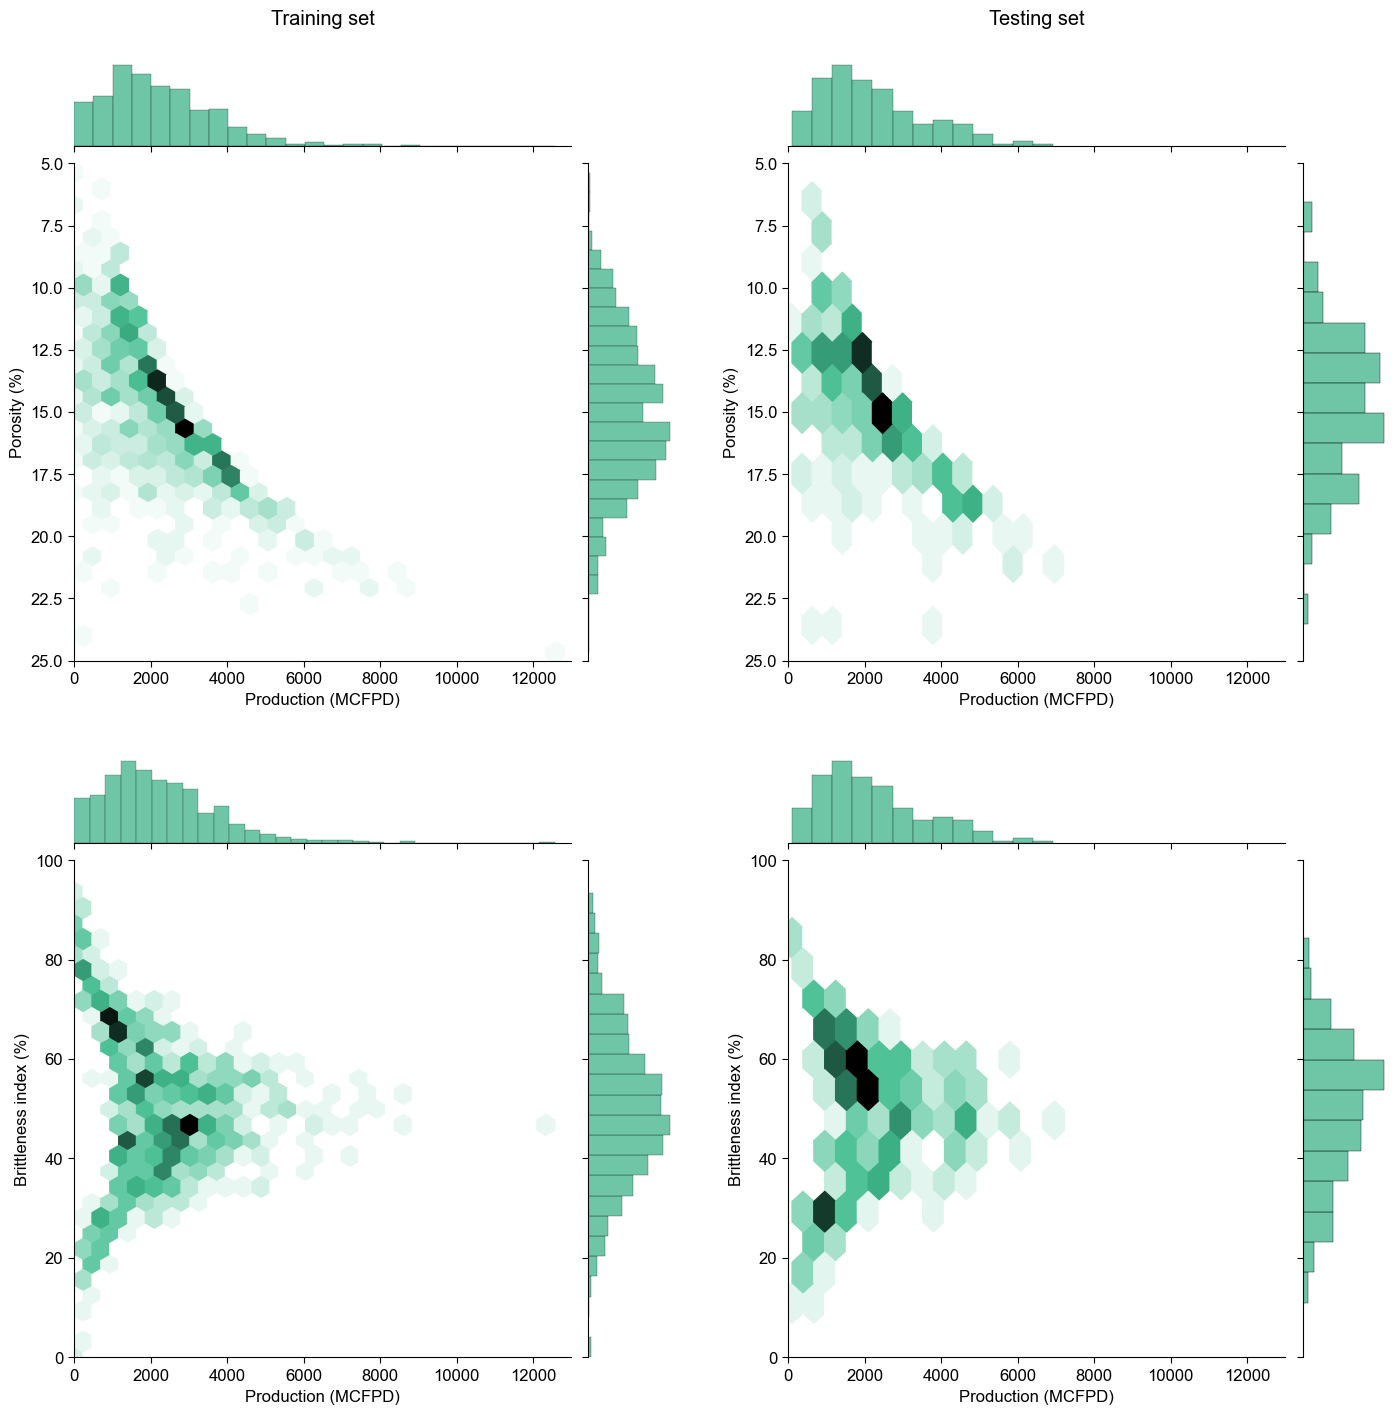

In [10]:
pw.overwrite_axisgrid() 

# Make joint plots for training data
g0 = sns.jointplot(x=Data_sub_train['Production'], y=Data_sub_train['Por'], kind="hex", color="#3EB489", xlim = {ProdMin, ProdMax}, ylim = {PorMin, PorMax}, marginal_kws=dict(bins=25, fill=True))
plt.xlabel('Production (MCFPD)')
plt.ylabel('Porosity (%)')
plt.title('Training set', pad = 100)
g0 = pw.load_seaborngrid(g0, label="g0")

g1 = sns.jointplot(x=Data_sub_train['Production'], y=Data_sub_train['Brittle'], kind="hex", color="#3EB489", xlim = {ProdMin, ProdMax}, ylim = {BrittleMin, BrittleMax})
plt.xlabel('Production (MCFPD)')
plt.ylabel('Brittleness index (%)')
g1 = pw.load_seaborngrid(g1, label="g1")

# Make joint plots for testing data
g2 = sns.jointplot(x=Data_sub_test['Production'], y=Data_sub_test['Por'], kind="hex", color="#3EB489", xlim = {ProdMin, ProdMax}, ylim = {PorMin, PorMax})
plt.xlabel('Production (MCFPD)')
plt.ylabel('Porosity (%)')
plt.title('Testing set', pad = 100)
g2 = pw.load_seaborngrid(g2, label="g2")

g3 = sns.jointplot(x=Data_sub_test['Production'], y=Data_sub_test['Brittle'], kind="hex", color="#3EB489", xlim = {ProdMin, ProdMax}, ylim = {BrittleMin, BrittleMax})
plt.xlabel('Production (MCFPD)')
plt.ylabel('Brittleness index (%)')
g3 = pw.load_seaborngrid(g3, label="g3")


((g0/g1)|(g2/g3)).savefig()

The dark green shows hexagonal data bins in the areas with high counts, making it easy to compare high density in the bivariate distributions. We see that there both permeability and brittleness have some correlation with production. Furthermore, the histograms look pretty good without any missing data or truncations.

Below we use a colored scatterplot to look at the how production varys within bivariate plots of the predictor features. This code snippet is from [Prof. Pyrcz's workflow on Gradient Boosting]((https://t.co/qzhPWHwEC0?amp=1). 

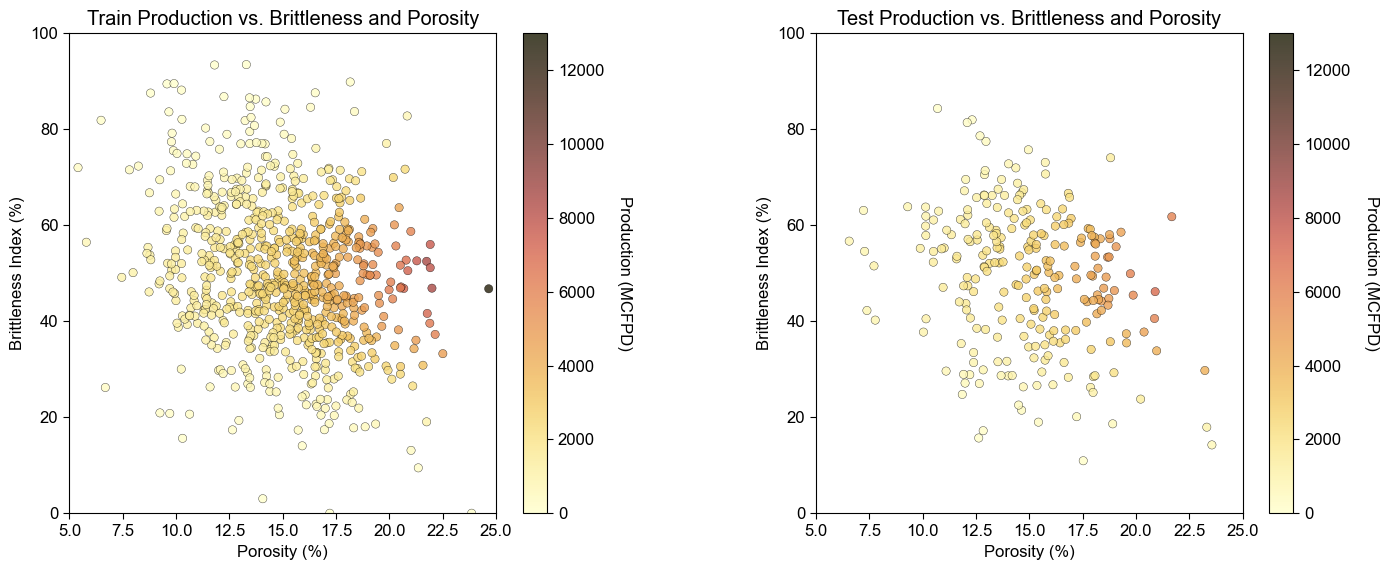

In [11]:
plt.close()
plt.subplot(121)                                  # plot the training data
im = plt.scatter(Data_sub_train["Por"],Data_sub_train["Brittle"],s=None, c=Data_sub_train["Production"], marker=None, cmap=cm.lajolla, norm=None, vmin=ProdMin, vmax=ProdMax, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Train Production vs. Brittleness and Porosity'); plt.xlabel('Porosity (%)'); plt.ylabel('Brittleness Index (%)')
plt.xlim(PorMin,PorMax);plt.ylim(BrittleMin,BrittleMax)
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label("Production (MCFPD)", rotation=270, labelpad=20)

plt.subplot(122)                                # plot the training data
im = plt.scatter(Data_sub_test["Por"],Data_sub_test["Brittle"],s=None, c=Data_sub_test["Production"], marker=None, cmap=cm.lajolla, norm=None, vmin=ProdMin, vmax=ProdMax, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Test Production vs. Brittleness and Porosity'); plt.xlabel('Porosity (%)'); plt.ylabel('Brittleness Index (%)')
plt.xlim(PorMin,PorMax);plt.ylim(BrittleMin,BrittleMax)
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label("Production (MCFPD)", rotation=270, labelpad=20)
 
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.4, hspace=0.3)
plt.show()


Here we see how production varies with both porosity and permeability and that the trends are comparable between the training and testing sets. That's good.   

The last thing to do before moving on to boosting is to split our datasets into predictors and response features (following [Prof. Pyrcz's workflow](https://t.co/qzhPWHwEC0?amp=1)).

In [12]:
predictors_train = Data_sub_train[['Por','Brittle']].copy()       # make a new DataFrame with predictor features for training
response_train = Data_sub_train[['Production']].copy()            # make a new DataFrame with responses features for training
predictors_test = Data_sub_test[['Por','Brittle']].copy() # make a new DataFrame with predictor features for testing
response_test = Data_sub_test[['Production']].copy()  # make a new DataFrame with responses for testing

### 2. Gradient boosting

Here I only provide a concise summary of the gradient boosting technique. You can find a detailed explanation of the gradient boosting method in the [SciKit learn documentation](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting), which explains the seminal work of [Friedman (2001)](https://projecteuclid.org/journals/annals-of-statistics/volume-29/issue-5/Greedy-function-approximation-A-gradient-boosting-machine/10.1214/aos/1013203451.full). And of course, [Prof. Pyrcz's lecture](https://www.youtube.com/watch?v=___T8_ixIwc&list=PLG19vXLQHvSC2ZKFIkgVpI9fCjkN38kwf&index=38&t=361s) is a great place to start. I source the summary below from those resources. 

Gradient boosting is an ensemble method in machine learning that begins by building a 'weak learner' model for the dataset (a decision stump - one decision and two regions). The residual is then calculated and fit with an additional “weak learner”. This method is an iterative process until the model reaches a suitable solution.

Main parameter considerations:

- __Tree size__: The tree size can be controlled with either the __*maximum_depth*__ or __*maximum_leaf_nodes*__ parameters. __*Maximum_depth*__ sets the depth of the tree with limited leaf nodes, while __*maximum_leaf_nodes*__ is as it sounds. From the documentation: __*Maximum_leaf_nodes*__ = k gives around the same result as __*maximum_depth*__ = k-1, but is faster with the trade-off of higher error. Considering this, let's use __*maximum_leaf_nodes*__.

- __Learning rate__: constrains the rate at which the solution is achieved by scaling the gradient descent step by a constant factor. The learning rate is typically in the range of 0.01 - 0.1. Too high of a learning rate risks overshooting the solution. Too low of a learning rate means the model takes longer to arrive at the solution. The learning rate interacts with the number of weak learners. The slower the learning rate, the more weak learners required for the fit. 

- __Criterion__: Measures the quality of a split. One can choose the __*friedman_mse*__ for mean squared error using an improvement score by Friedman (see paper linked above) or __*squared error*__ for mean squared error. From the documentation, "The default value of
    "friedman_mse" is generally the best as it can provide a better
    approximation in some cases." For this reason we use the __*friedman_mse*__
    
- __Loss function__: There are several options for a loss function including: __*Quantile*__, __*Huber*__, __*Least absolute deviation*, and *squared error*__. These can be read about in the sklearn documentation and Friedman paper. We use __*squared error*__ considering its better computational efficiency. 

The code block below builds the interactive GUI for Gradient Boosting. These are all inspired by the one in [Prof. Pyrcz's correlation coefficient interactive workflow](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/Interactive_Correlation_Coefficient.ipynb).

In [13]:
# dashboard: number of trees, number of leaf nodes, and learning rate
style = {'description_width': 'initial'}
l = widgets.Text(value='                                              Gradient boosting - Ethan Conrad (based on Correlation Coefficient widget, Michael Pyrcz',layout=Layout(width='950px', height='30px'))
num_tree = widgets.IntSlider(min = 1, max = 500, value = 50, step = 1, description = r'number of trees',orientation='horizontal',continuous_update=True,
                          layout=Layout(width='600px', height='40px'))
num_tree.style.handle_color = 'gray'

max_leaf_nodes = widgets.IntSlider(min = 2, max = 15, value = 50, step = 1, description = r'Maximum Leaf Nodes',orientation='horizontal',continuous_update=True,
                          layout=Layout(width='600px', height='40px'))
max_leaf_nodes.style.handle_color = 'gray'

learning_rate = widgets.FloatSlider(min = 0.01, max = 1, value = 0.01, step = 0.01, description = r'Learning Rate',orientation='horizontal',continuous_update=True,
                          layout=Layout(width='600px', height='40px'))
learning_rate.style.handle_color = 'gray'

uipars = widgets.HBox([num_tree,max_leaf_nodes, learning_rate],)     

uik = widgets.VBox([l,uipars],)

output = widgets.Output()
    
# connect the function to make the samples and plot to the widgets    
interactive_plot = widgets.interactive_output(GradBoost_make, {'num_tree':num_tree,'max_leaf_nodes':max_leaf_nodes, 'learning_rate':learning_rate})
interactive_plot.clear_output(wait = True)               # reduce flickering by delaying plot updating

Execute UI

In [14]:
display(uik, interactive_plot)                            # display the interactive plot

Output()

We can explore how the parameters interact to affect the model by experimenting with the GUI sliders above. Below I describe two examples.

__Trade off between learning rate and number of trees (keeping the number of leaf nodes constant):__  
As described above, lowering the learning rate requires more trees to obtain a desirable solution. For example, to get a decent solution at a low learning rate (0.01), you must maximize the number of trees slider to >200.

__Interaction between the number of leaf nodes and the number of trees (keep the learning rate constant at 1):__  
The number of leaf nodes affects the solution more significantly when the number of trees is low. This behavior occurs simply because the problem reduces to decision tree regression at a low number of trees. So, by increasing the number of leaf nodes, the fit will improve until the model is overfit. In other words, the number of leaf nodes pushes the initial "weak learner" to a "strong learner". At some number of trees, more complex individual trees do not significantly change the error in the model because the summation of weak learners outweighs the impact of tree complexity. For example, try changing the number of leaf nodes with 500 trees and comparing the result to the change in model error with 2 trees. This exercise demonstrates the central concept of the gradient boosting method: the summation of several "weak learners" performs significantly better than a single (or a few) "strong learner (s)".

Now we can explore optimizing the model hyperparameters by visualizing it in 3 dimensions.    

The code block below generates a 3-D grid of the changing model parameters, then uses those parameters to fit a gradient boosting model and returns the MSE at each grid point. For speed, change the data load option to 1 so that a precalculated grid is imported from GitHub.

In [15]:
DataLoadOption = 1 # change this to create a new grid (0) or import an already created one (1, much faster!).
if DataLoadOption == 0:
    test_dim = 20 # set dimensions of grid
    # Create vectors to pass into boosting algoritms
    learning_rate_vector = np.linspace(0.01, 1.1, test_dim)
    nodes_vector = np.int8(np.round(np.linspace(2,101,test_dim)))
    number_trees_vector = np.int8(np.round(np.linspace(1,101,test_dim)))

    # Instantiate variables
    df_4D_grad['MSE'] = [] # MSE for gradient boosting
    lr_grad = [] # Learning rate for gradient boosting
    nv_grad = [] # Number of leaf nodes for gradient boosting
    nt_grad = [] # Number of trees for gradient boosting

    # Iterate through all parameters
    for i in learning_rate_vector:
        for j in nodes_vector:
            for k in number_trees_vector:
                lr_grad.append(i)
                nv_grad.append(j)
                nt_grad.append(k)
                SE_grad.append(ReturnGradientBoostMSE(k,j,i))
    write_array = np.column_stack([lr_grad, nv_grad, nt_grad, SE_grad])
    df_4D_grad = pd.DataFrame(write_array, columns = ['Learning rates','Number of leaf nodes','Number of trees', 'MSE'])
    
# To speed up workflow, you may load the default data from GitHub
elif DataLoadOption == 1:
    df_4D_grad = pd.read_csv(r"https://raw.githubusercontent.com/AnOkGeologist/Boosting-Workflow-Data/master/GradientBoostingGrid.csv")
    

Now we can visualize the data on a 3D interactive plot. The code block below finds the minimum MSE at for each boosting parameter then slices the data at that location.

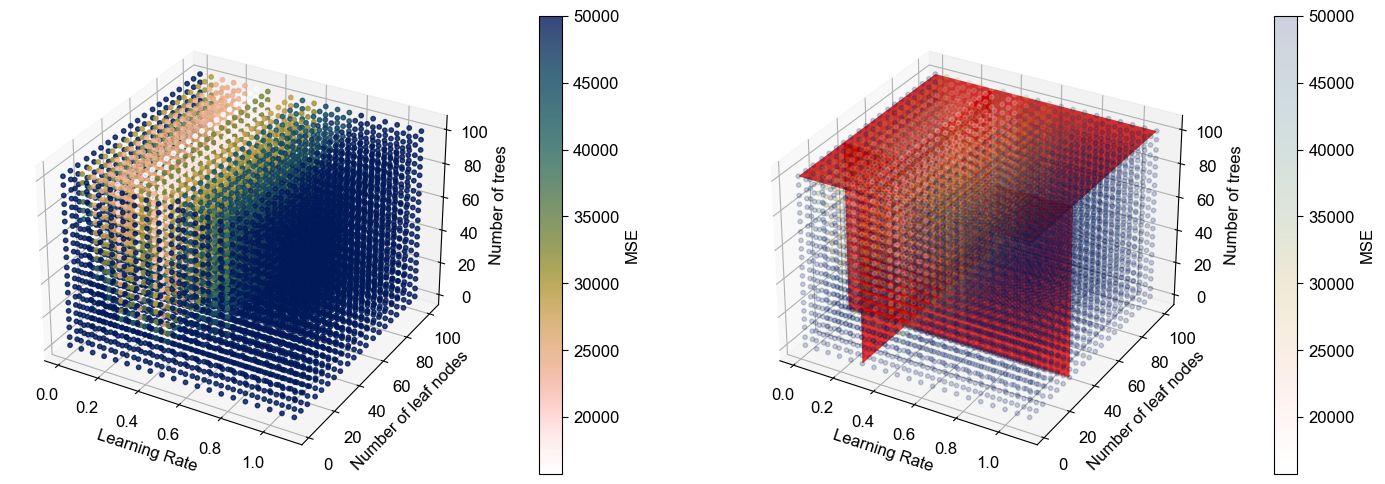

In [16]:
# uncomment below to make plot interactive (widget) or not interactive (inline) 
# %matplotlib widget 
# %matplotlib inline

# Create figure
fig = plt.figure(figsize = (15,5))

# Scatter plot for visualizing MSE across parameters
ax1 = fig.add_subplot(121, projection='3d')
a1 = ax1.scatter3D(df_4D_grad['Learning rates'], df_4D_grad['Number of leaf nodes'], df_4D_grad['Number of trees'], c=df_4D_grad['MSE'], s = 10, cmap=cm.batlowW.reversed(), alpha = 0.8, vmin = df_4D_grad['MSE'][np.argmin(df_4D_grad['MSE'])], vmax = 50000);
ax1.set_xlabel('Learning Rate')
ax1.set_ylabel('Number of leaf nodes')
ax1.set_zlabel('Number of trees')
cbar = plt.colorbar(a1, orientation = 'vertical', ax = ax1, pad = .1, label = 'MSE')

# Scatter plot with slices at the minimum MSE
ax2 = fig.add_subplot(122, projection='3d')

dim_lr = [0.01, 1.1] # Dimensions of learning rate
dim_nv = [2, 101] # Dimensions of number of nodes
dim_nt = [1, 101] # Dimensions of number of trees

# Create slice for number of trees at minimum MSE
Xnt, Ynt = np.meshgrid(dim_lr, dim_nv) # x and y grids
Zloc = df_4D_grad['Number of trees'][np.argmin(df_4D_grad['MSE'])] # location of MSE minimum within number of trees array
Znt = np.ones([2,2])*Zloc # create tree slice

# Create slice for learning rate at minimum MSE
Xlr, Ylr = np.meshgrid(dim_nv, dim_nt) # x and y grids
Zloc = df_4D_grad['Learning rates'][np.argmin(df_4D_grad['MSE'])] # locations of MSE minimum within learning rate array
Zlr = np.ones([2,2])*Zloc # create learning rate slice

# Create slice for number of nodes at minimum MSE
Xnv, Ynv = np.meshgrid(dim_nt, dim_lr) # x and y grids
Zloc = df_4D_grad['Number of leaf nodes'][np.argmin(df_4D_grad['MSE'])] # locations of MSE minimum within number of nodes array
Znv = np.ones([2,2])*Zloc # create number of nodes slice

# Plot slices
ax2.plot_surface(Xnt, Znv, Ylr, color='red', alpha=0.8, linewidth=0)
ax2.plot_surface(Xnt, Ynt, Znt, color='red', alpha=0.8, linewidth=0)
ax2.plot_surface(Zlr, Ynt, Xnv, color='red', alpha=0.8, linewidth=0)

# Show scatter plot over slices
a2 = ax2.scatter3D(df_4D_grad['Learning rates'], df_4D_grad['Number of leaf nodes'], df_4D_grad['Number of trees'], c=df_4D_grad['MSE'], s = 10, cmap=cm.batlowW.reversed(), alpha = 0.2, vmin = df_4D_grad['MSE'][np.argmin(df_4D_grad['MSE'])], vmax = 50000);
ax2.set_xlabel('Learning Rate')
ax2.set_ylabel('Number of leaf nodes')
ax2.set_zlabel('Number of trees')
cbar = plt.colorbar(a2, orientation = 'vertical', ax = ax2, pad = .1, label = 'MSE')

fig.tight_layout()
plt.show()


From the plot on the left, we can get an idea of the relative importance of each parameter for the model error. The low error region takes on the shape of a half-pipe, where the axis is the number of leaf nodes. This shape suggests that the number of leaf nodes does not strongly affect the model error. The plot on the right shows 2-D slices through the minimum MSE. If you have the time, recreate and replot the grid (i.e., re-run the 2 code blocks above). When this is done, the optimum number of leaf nodes will change, suggesting that the parameter has no impact within a reasonable parameter space.  

Now we can view the MSE withing the 2-D slices by plotting the slices above (MSE minimums along each axis). 

Optimized learning rate =  0.2968421052631579
Optimized number of trees =  101.0
Optimized number of leaf nodes =  33.0
Minimum MSE = 15771.873477029178


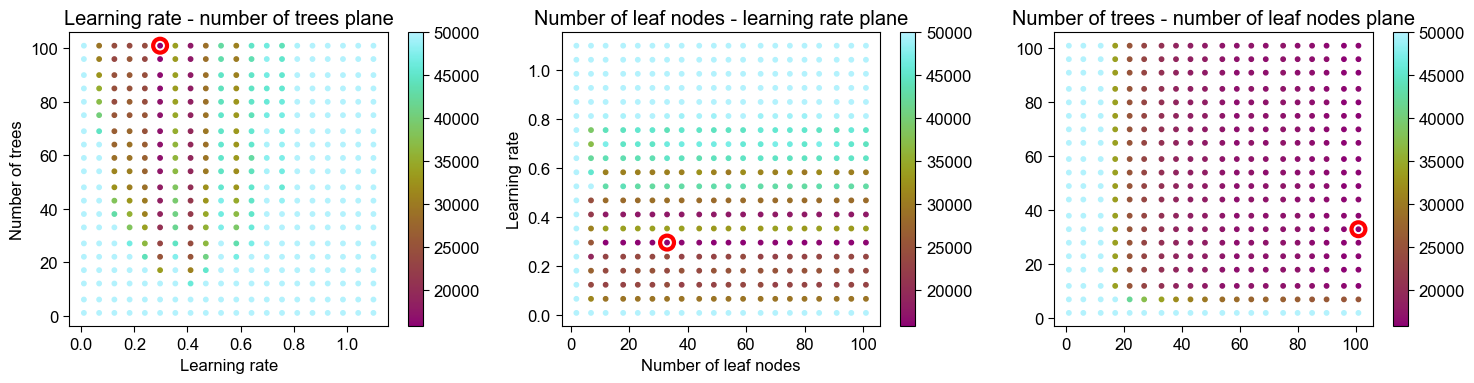

In [17]:
plt.close() # this is neccesary to break out of 3d space

# Find optimum values for learning rate (lr), number of trees (nt), and number of leaf nodes (nv)
Optim_lr_grad = df_4D_grad['Learning rates'][np.argmin(df_4D_grad['MSE'])]
Optim_nt_grad = df_4D_grad['Number of trees'][np.argmin(df_4D_grad['MSE'])]
Optim_nv_grad = df_4D_grad['Number of leaf nodes'][np.argmin(df_4D_grad['MSE'])]

print('Optimized learning rate = ', Optim_lr_grad)
print('Optimized number of trees = ', Optim_nt_grad)
print('Optimized number of leaf nodes = ', Optim_nv_grad)
print('Minimum MSE =', df_4D_grad['MSE'][np.argmin(df_4D_grad['MSE'])])


fig,ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15,4))

# Slice parameter lists where the MSE is minimized

## Learning rate - # of trees plane
MSE_ind = np.where(df_4D_grad['Number of leaf nodes'] == df_4D_grad['Number of leaf nodes'][np.argmin(df_4D_grad['MSE'])])
lr_slice_nv = np.array(df_4D_grad['Learning rates'])[MSE_ind]
nt_slice_nv = np.array(df_4D_grad['Number of trees'])[MSE_ind]
ax0 = ax[0].scatter(lr_slice_nv, nt_slice_nv, s=10, c=np.array(df_4D_grad['MSE'])[MSE_ind], cmap = cm.hawaii, vmin = df_4D_grad['MSE'][np.argmin(df_4D_grad['MSE'])], vmax = 50000)
colors = np.array(df_4D_grad['MSE'])[MSE_ind]
ax[0].scatter(df_4D_grad['Learning rates'][np.argmin(df_4D_grad['MSE'])], df_4D_grad['Number of trees'][np.argmin(df_4D_grad['MSE'])], s=100, color= 'none', edgecolor = 'red', linewidths=3) # circle minimum
ax[0].set_title('Learning rate - number of trees plane')
ax[0].set_xlabel('Learning rate')
ax[0].set_ylabel('Number of trees')
cbar = plt.colorbar(ax0, orientation = 'vertical', ax = ax[0])

# cbar.set_label("Production", rotation=270, labelpad=20)

## # of leaf nodes - learning rate plate
MSE_ind = np.where(df_4D_grad['Number of trees'] == df_4D_grad['Number of trees'][np.argmin(df_4D_grad['MSE'])])
lr_slice_nt = np.array(df_4D_grad['Learning rates'])[MSE_ind]
nv_slice_nt = np.array(df_4D_grad['Number of leaf nodes'])[MSE_ind]
ax1 = ax[1].scatter(nv_slice_nt, lr_slice_nt, s=10, c=np.array(df_4D_grad['MSE'])[MSE_ind], cmap = cm.hawaii, vmin = df_4D_grad['MSE'][np.argmin(df_4D_grad['MSE'])], vmax = 50000)
ax[1].scatter(df_4D_grad['Number of leaf nodes'][np.argmin(df_4D_grad['MSE'])], df_4D_grad['Learning rates'][np.argmin(df_4D_grad['MSE'])], s=100, color= 'none', edgecolor = 'red', linewidths=3) # circle minimum
ax[1].set_title('Number of leaf nodes - learning rate plane')
ax[1].set_xlabel('Number of leaf nodes')
ax[1].set_ylabel('Learning rate')
cbar = plt.colorbar(ax1, orientation = 'vertical', ax = ax[1])

# # of trees - # of leaf nodes plane
MSE_ind = np.where(df_4D_grad['Learning rates'] == df_4D_grad['Learning rates'][np.argmin(df_4D_grad['MSE'])])
nt_slice_lr = np.array(df_4D_grad['Number of trees'])[MSE_ind]
nv_slice_lr = np.array(df_4D_grad['Number of leaf nodes'])[MSE_ind]
ax2 = ax[2].scatter(nt_slice_lr, nv_slice_lr, s=10, c=np.array(df_4D_grad['MSE'])[MSE_ind], cmap = cm.hawaii, vmin = df_4D_grad['MSE'][np.argmin(df_4D_grad['MSE'])], vmax = 50000)
ax[2].scatter(df_4D_grad['Number of trees'][np.argmin(df_4D_grad['MSE'])], df_4D_grad['Number of leaf nodes'][np.argmin(df_4D_grad['MSE'])], s=100, color= 'none', edgecolor = 'red', linewidths=3) # circle minimum
ax[2].set_title('Number of trees - number of leaf nodes plane')
cbar = plt.colorbar(ax2, orientation = 'vertical', ax = ax[2])


fig.tight_layout()
plt.show()


Great! From this, we can see how each parameter controls the minimization of the MSE. The learning rate has a minimum impact when greater than ~0.6 yet has a steep gradient when below this value. In comparison, the number of trees has a more gradual slope and larger range where it insignificantly impacts the minimization. Once again, across a range of values, the number of leaf nodes does not significantly affect the MSE. Let's repeat the steps above for adaptive boosting (AdaBoost) and compare the results.

### 3. Adaptive boosting (AdaBoost) for regression
Again, here I only summarize what can be found in the [Scikitlearn documentation](https://scikit-learn.org/stable/modules/ensemble.html#adaboost) and the paper by [Freund and Schapire (1997)](https://www-sciencedirect-com.ezproxy.lib.utexas.edu/science/article/pii/S002200009791504X) which established the method.

Like gradient boosting, the concept of Ada boost is to fit weak learners (e.g., decision stumps) on repeatedly altered instances of the data. The predictions from each instance are then combined using a weighted majority sum to make the final prediction. The modifications between model realizations are weights applied to each training sample. The initial weak learner iteration sets the weights to 1/N, where N is the total data. The weights are then modified based on the predictions of the previous step. If they were incorrectly predicted, the weights are increased. Therefore, difficult-to-predict data subsequently receive a higher weight. 

__Parameter considerations__:
Some key features set AdaBoost apart from gradient boosting:
- __Base estimator__: the regressor from which the ensemble is built. So that the results are comparable with the gradient boosting method, we use the default, the decision tree regressor.  

- __Other parameters__ Because we are using a decision tree regressor, we can compare how similar parameters in the gradient boosting regressor change the AdaBoost model and then compare the models. 

Below I repeat the workflow above for AdaBoosting

In [18]:
# dashboard: number of trees, number of leaf nodes, and learning rate
style = {'description_width': 'initial'}
l = widgets.Text(value='                                              Ada boosting - Ethan Conrad (based on Correlation Coefficient widget, Michael Pyrcz',layout=Layout(width='950px', height='30px'))
num_tree = widgets.IntSlider(min = 1, max = 500, value = 5, step = 1, description = r'Number of Trees',orientation='horizontal',continuous_update=True,
                          layout=Layout(width='600px', height='40px'))
num_tree.style.handle_color = 'gray'

max_leaf_nodes = widgets.IntSlider(min = 2, max = 15, value = 5, step = 1, description = r'Maximum Leaf Nodes',orientation='horizontal',continuous_update=True,
                          layout=Layout(width='600px', height='40px'))
max_leaf_nodes.style.handle_color = 'gray'

learning_rate = widgets.FloatSlider(min = 0.01, max = 1, value = 0.01, step = 0.01, description = r'Learning Rate',orientation='horizontal',continuous_update=True,
                          layout=Layout(width='600px', height='40px'))
learning_rate.style.handle_color = 'gray'

uipars = widgets.HBox([num_tree,max_leaf_nodes, learning_rate],)     

uik = widgets.VBox([l,uipars],)

output = widgets.Output()
    
# connect the function to make the samples and plot to the widgets    
interactive_plot = widgets.interactive_output(AdaBoost_make, {'num_tree':num_tree,'max_leaf_nodes':max_leaf_nodes, 'learning_rate':learning_rate})
interactive_plot.clear_output(wait = True)               # reduce flickering by delaying plot updating

Execute UI

In [19]:
display(uik, interactive_plot)                            # display the interactive plot

Output()

We can already see differences between the AdaBoost and GradientBoosting approaches. Namely, the AdaBoost solution is more complex and thus smoother.   

Once again, we can explore how the parameters interact to affect the model by experimenting with the GUI sliders above.

__Trade off between learning rate and number of trees (keeping the number of leaf nodes constant):__  
While the trade-off between the learning rate and the number of trees still exists, the learning rate has a much smaller impact on the prediction error. For example, increase the number of trees to 500 and manipulate the learning rate slider. While a higher learning rate still results in a slightly better agreement between actual and estimated production, it is not nearly as impactful as in the gradient boosting method. 

__Interaction between the number of leaf nodes and the number of trees (keep the learning rate constant at 1):__  
Like the trade-off between the learning rate and the number of trees, we see a different interaction between the number of leaf nodes and the number of trees in the Adaboost method. For example, try keeping the number of trees low (2) and changing the number of leaf nodes. Then, try the opposite, keep the number of trees high, and change the number of leaf nodes. In both cases, there is a significant reduction in the model error when the number of leaf nodes is increased. 

How can we explain these behaviors, specifically the much more important role of the number of leaf nodes? Both are likely a result of the role of weighing misclassified data in the AdaBoost methodology. As the name suggests, the AdaBoost approach is adaptive, so a higher number of leaf nodes, or decision tree splits, allows the model to respond more directly to the changing weights with each step and more effectively capture complexity in the data. Furthermore, the changing weights and misclassifications mean that the descent down the loss function is not as smooth, resulting in a less stable solution. As we will see below, optimizing the parameters is more complicated and non-unique with each model realization. Taken together, this highlights the inflexibility of the AdaBoosting approach. 

Okay, let's do our 3-D optimization again for AdaBoost. We need to recreate our vectors. Warning: this will take a while to [loop](https://www.youtube.com/watch?v=CvcoxunP7KU)!

Once again, for speed, change the data load option to 1 so that a precalculated grid is imported from GitHub.

In [20]:
DataLoadOption = 1 # change this to create a new grid (0) or import an already created one (1, much faster!).

if DataLoadOption == 0:
    
    test_dim = 20 # set dimensions of grid

    # Set up vectors to pass into the AdaBoosting algorithm
    learning_rate_vector = np.linspace(0.01, 1.1, test_dim)
    nodes_vector = np.int8(np.round(np.linspace(2,101,test_dim)))
    number_trees_vector = np.int8(np.round(np.linspace(1,101,test_dim)))

    # Instantiate variables
    SE_ada = []
    lr_ada = []
    nv_ada = []
    nt_ada = []

    # Loop through
    for i in learning_rate_vector:
        for j in nodes_vector:
            for k in number_trees_vector:
                lr_ada.append(i)
                nv_ada.append(j)
                nt_ada.append(k)
                SE_ada.append(ReturnAdaMSE(k,j,i))

   
    write_array = np.column_stack([lr_ada, nv_ada, nt_ada, SE_ada])
    df_4D_ada = pd.DataFrame(write_array, columns = ['Learning rates','Number of leaf nodes','Number of trees', 'MSE'])
    
elif DataLoadOption == 1:
    df_4D_ada = pd.read_csv(r"https://raw.githubusercontent.com/AnOkGeologist/Boosting-Workflow-Data/master/AdaBoostingGrid.csv")

Now we can visualize the data on a 3D interactive plot. The code block below finds the minimum MSE at for each boosting parameter then slices the data at that location.

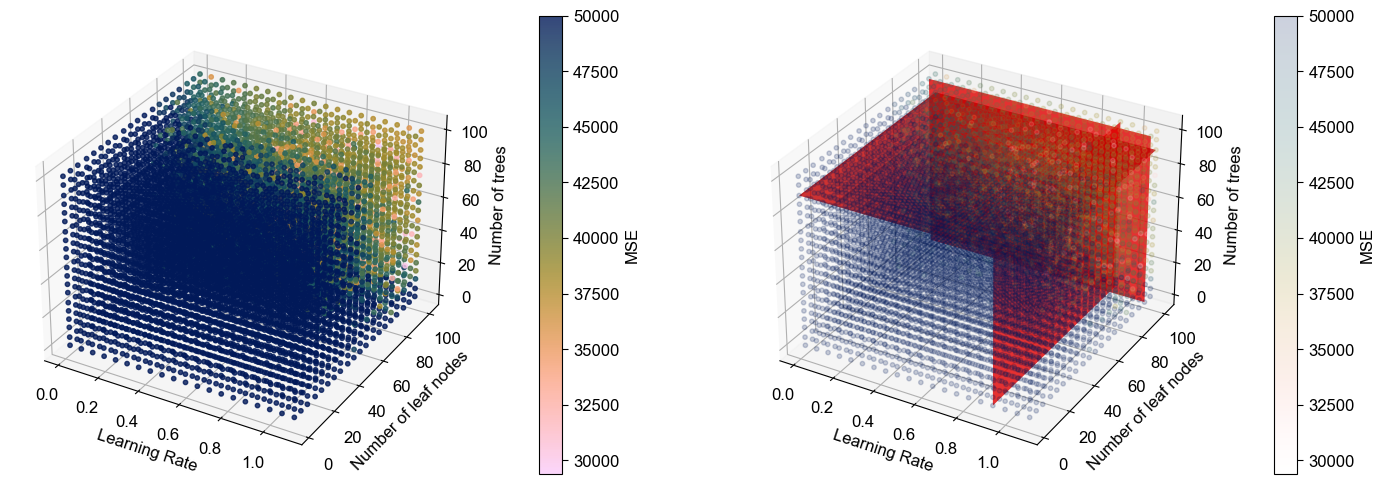

In [21]:
# uncomment below to make plot interactive (widget) or not interactive (inline) 
# %matplotlib widget 
# %matplotlib inline

# Create figure
fig = plt.figure(figsize = (15,5))

# Scatter plot for visualizing MSE across parameters
ax1 = fig.add_subplot(121, projection='3d')
a1 = ax1.scatter3D(df_4D_ada['Learning rates'], df_4D_ada['Number of leaf nodes'], df_4D_ada['Number of trees'], c=df_4D_ada['MSE'], s = 10, cmap=cm.batlow.reversed(), alpha = 0.8, vmin = df_4D_ada['MSE'][np.argmin(df_4D_ada['MSE'])], vmax = 50000);
ax1.set_xlabel('Learning Rate')
ax1.set_ylabel('Number of leaf nodes')
ax1.set_zlabel('Number of trees');
cbar = plt.colorbar(a1, orientation = 'vertical', ax = ax1, pad = .1, label = 'MSE')

# Scatter plot with slices at the minimum MSE
ax2 = fig.add_subplot(122, projection='3d')

dim_lr = [0.01, 1.1] # Learning rate dimensions
dim_nv = [2, 101] # Number of nodes dimensions
dim_nt = [1, 101] # Number of trees dimensions

# Create slice for number of trees
Xnt, Ynt = np.meshgrid(dim_lr, dim_nv) # x and y grid
Zloc = df_4D_ada['Number of trees'][np.argmin(df_4D_ada['MSE'])] # find location where MSE is minimized
Znt = np.ones([2,2])*Zloc # create slice

# Create slice for learning rate
Xlr, Ylr = np.meshgrid(dim_nv, dim_nt) # x and y grid
Zloc = df_4D_ada['Learning rates'][np.argmin(df_4D_ada['MSE'])] # find location where MSE is minimized
Zlr = np.ones([2,2])*Zloc # create slice

# Create slice for number of leaf nodes
Xnv, Ynv = np.meshgrid(dim_nt, dim_lr) # x and y grid
Zloc = df_4D_ada['Number of leaf nodes'][np.argmin(df_4D_ada['MSE'])] # find location where MSE is minimized
Znv = np.ones([2,2])*Zloc # create slice

# Plot slices
ax2.plot_surface(Xnt, Znv, Ylr, color='red', alpha=0.8, linewidth=0)
ax2.plot_surface(Xnt, Ynt, Znt, color='red', alpha=0.8, linewidth=0)
ax2.plot_surface(Zlr, Ynt, Xnv, color='red', alpha=0.8, linewidth=0)

# Plot data over slices
a2 = ax2.scatter3D(df_4D_ada['Learning rates'], df_4D_ada['Number of leaf nodes'], df_4D_ada['Number of trees'], c=df_4D_ada['MSE'], s = 10, cmap=cm.batlowW.reversed(), alpha = 0.2, vmin = df_4D_ada['MSE'][np.argmin(df_4D_ada['MSE'])], vmax = 50000);
ax2.set_xlabel('Learning Rate')
ax2.set_ylabel('Number of leaf nodes')
ax2.set_zlabel('Number of trees');
cbar = plt.colorbar(a2, orientation = 'vertical', ax = ax2, pad = .1, label = 'MSE')

fig.tight_layout()
plt.show()

Here we can see how complex the AdaBoost MSE results are. From the plot on the left, we see that the shape of the low error region is wedge-shaped and that the long portion of the wedge is parallel to the learning rate axis, supporting the observations made in the tests above. In addition, the wedge tapers (requires fewer leaf nodes to reduce error) with fewer trees. This observation is interesting because it is, in a way, similar to the gradient boosting maxim regarding the summation of "weak learners" - it is reasonable to say that the combination of many "weak learners" can perform just as well as a combination of a few "strong learners". Although, reversing this thinking shows that a reasonable model can be created with more complex trees and fewer model iterations. We will see below that the wedge also tapers slightly along the learning rate axis, meaning that a low-error solution can be reached more reliably with higher learning rates.

Now we can view the MSE withing the 2-D slices by plotting the slices above (MSE minimums along each axis). 

Optimized learning rate =  0.9278947368421052
Optimized number of trees =  90.0
Optimized number of leaf nodes =  96.0
Minimum MSE = 29401.496898019446


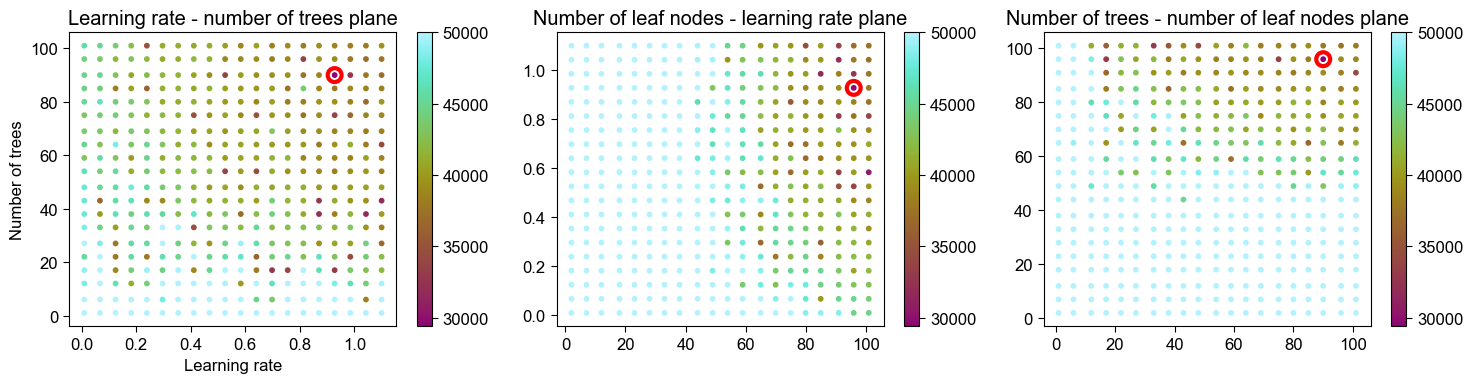

In [22]:
plt.close() # this is neccesary to break out of 3d space

# Find optimum values for learning rate (lr), number of trees (nt), and number of leaf nodes (nv)
Optim_lr_ada = df_4D_ada['Learning rates'][np.argmin(df_4D_ada['MSE'])]
Optim_nt_ada = df_4D_ada['Number of trees'][np.argmin(df_4D_ada['MSE'])]
Optim_nv_ada = df_4D_ada['Number of leaf nodes'][np.argmin(df_4D_ada['MSE'])]

print('Optimized learning rate = ', Optim_lr_ada)
print('Optimized number of trees = ', Optim_nt_ada)
print('Optimized number of leaf nodes = ', Optim_nv_ada)
print('Minimum MSE =', df_4D_ada['MSE'][np.argmin(df_4D_ada['MSE'])])

fig,ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15,4))

# Slice parameter lists where the MSE is minimized

## Learning rate - # of trees plane
MSE_ind = np.where(df_4D_ada['Number of leaf nodes'] == df_4D_ada['Number of leaf nodes'][np.argmin(df_4D_ada['MSE'])])
lr_slice_nv = np.array(df_4D_ada['Learning rates'])[MSE_ind]
nt_slice_nv = np.array(df_4D_ada['Number of trees'])[MSE_ind]
ax0 = ax[0].scatter(lr_slice_nv, nt_slice_nv, s=10, c=np.array(df_4D_ada['MSE'])[MSE_ind], cmap = cm.hawaii, vmin = df_4D_ada['MSE'][np.argmin(df_4D_ada['MSE'])], vmax = 50000)
colors = np.array(df_4D_ada['MSE'])[MSE_ind]
ax[0].scatter(df_4D_ada['Learning rates'][np.argmin(df_4D_ada['MSE'])], df_4D_ada['Number of trees'][np.argmin(df_4D_ada['MSE'])], s=100, color= 'none', edgecolor = 'red', linewidths=3)
ax[0].set_title('Learning rate - number of trees plane')
ax[0].set_xlabel('Learning rate')
ax[0].set_ylabel('Number of trees')
cbar = plt.colorbar(ax0, orientation = 'vertical', ax = ax[0])

# cbar.set_label("Production", rotation=270, labelpad=20)

## # of leaf nodes - learning rate plate
MSE_ind = np.where(df_4D_ada['Number of trees'] == df_4D_ada['Number of trees'][np.argmin(df_4D_ada['MSE'])])
lr_slice_nt = np.array(df_4D_ada['Learning rates'])[MSE_ind]
nv_slice_nt = np.array(df_4D_ada['Number of leaf nodes'])[MSE_ind]
ax1 = ax[1].scatter(nv_slice_nt, lr_slice_nt, s=10, c=np.array(df_4D_ada['MSE'])[MSE_ind], cmap = cm.hawaii, vmin = df_4D_ada['MSE'][np.argmin(df_4D_ada['MSE'])], vmax = 50000)
ax[1].scatter(df_4D_ada['Number of leaf nodes'][np.argmin(df_4D_ada['MSE'])], df_4D_ada['Learning rates'][np.argmin(df_4D_ada['MSE'])], s=100, color= 'none', edgecolor = 'red', linewidths=3)
ax[1].set_title('Number of leaf nodes - learning rate plane')
cbar = plt.colorbar(ax1, orientation = 'vertical', ax = ax[1])

# # of trees - # of leaf nodes plane
MSE_ind = np.where(df_4D_ada['Learning rates'] == df_4D_ada['Learning rates'][np.argmin(df_4D_ada['MSE'])])
nt_slice_lr = np.array(df_4D_ada['Number of trees'])[MSE_ind]
nv_slice_lr = np.array(df_4D_ada['Number of leaf nodes'])[MSE_ind]
ax2 = ax[2].scatter(nt_slice_lr, nv_slice_lr, s=10, c=np.array(df_4D_ada['MSE'])[MSE_ind], cmap = cm.hawaii, vmin = df_4D_ada['MSE'][np.argmin(df_4D_ada['MSE'])], vmax = 50000)
ax[2].scatter(df_4D_ada['Number of trees'][np.argmin(df_4D_ada['MSE'])], df_4D_ada['Number of leaf nodes'][np.argmin(df_4D_ada['MSE'])], s=100, color= 'none', edgecolor = 'red', linewidths=3)
ax[2].set_title('Number of trees - number of leaf nodes plane')
cbar = plt.colorbar(ax2, orientation = 'vertical', ax = ax[2])

## Learning rate - # of trees plane
lr_slice = np.array(df_4D_ada['Learning rates'])[MSE_ind]
nt_slice = np.array(df_4D_ada['Number of trees'])[MSE_ind]

fig.tight_layout()
plt.show()


Again we see the increased complexity of AdaBoost relative to gradient boosting. As mentioned above, the MSE slices do not follow a smooth gradient toward the lowest MSE value. Instead, they are much rougher, with high and low points mixed in low MSE regions. Furthermore, from the trends along the learning rate axes, it is possible to pick a much lower learning rate and achieve similar predictions. The concentration of low MSE points and high gradients along the number of leaf nodes axis also supports the notion that the tree complexity is more important in the AdaBoost methodology than in gradient boosting.

### 4. Results

Concerning the quality of the predictions, the Gradient boosting approach produces a lower MSE with the optimized prediction (Mdf_4D_grad['MSE'] = ~15771 vs Mdf_4D_ada['MSE'] = ~29402). For example, let's look at how the MSE changes with each model keeping the optimized learning rate and leaf nodes, with a few more samples of the number of trees.

Let's start by calculating those vectors. Once more, the option to import the data from GitHub is available for speed. 

In [23]:
DataLoadOption = 1 # change this to create a new grid (0) or import an already created one (1, much faster!).

if DataLoadOption == 0:
    
    test_dim = 100 # number of trees to test
    number_trees_vector = np.int8(np.round(np.linspace(1,101,test_dim))) # set maximum and minimum here

    # Instantiate vars
    SE_ada_test = []
    SE_grad_test = []

    # loop through number of trees and calculate MSE
    for i in number_trees_vector:
        SE_ada_test.append(ReturnAdaMSE(i,np.int8(Optim_nv_ada), Optim_lr_ada))
        SE_grad_test.append(ReturnGradientBoostMSE(i, np.int8(Optim_nv_grad), Optim_lr_grad))                  
        write_array = np.column_stack([SE_ada_test, SE_grad_test])
        df_test_grad = pd.DataFrame(write_array, columns = ['MSE Ada test','MSE Grad test'])
elif DataLoadOption == 1:
    test_dim = 100 # number of trees to test
    number_trees_vector = np.int8(np.round(np.linspace(1,101,test_dim))) # set maximum and minimum here
    df_test_grad = pd.read_csv(r"https://raw.githubusercontent.com/AnOkGeologist/Boosting-Workflow-Data/master/MSE_AdaNGradAcrossTrees.csv")


To visualize and compare the differences in AdaBoost and gradient boosting performance with optimized learning rate and number of leaf node parameters, let's plot the results of both the AdaBoost and Gradient boost across an increasing number of trees.

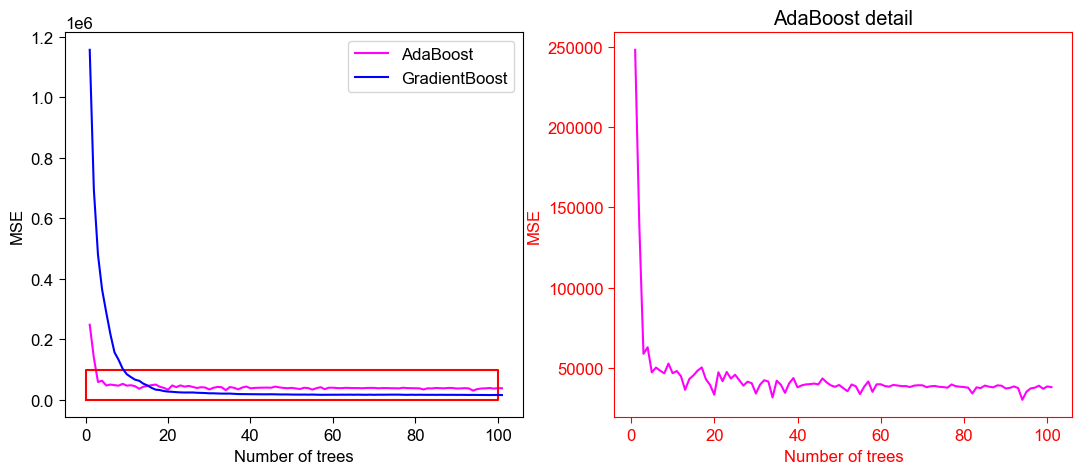

In [24]:
fig = plt.figure(figsize = (13,5))
ax = fig.add_subplot(121)

# Create MSE optimization plot with AdaBoost and Gradient boost
ax.plot(number_trees_vector, df_test_grad['MSE Ada test'], color = 'magenta', label = 'AdaBoost')
ax.plot([0, 0, 100, 100, 0], [0, 0.1e6, 0.1e6, 0, 0], color = 'red') # create zoom box
ax.plot(number_trees_vector, df_test_grad['MSE Grad test'], color = 'blue', label = 'GradientBoost')
ax.set_xlabel('Number of trees')
ax.set_ylabel('MSE')
plt.legend()

# Create zoom for the box in red in the leftmost plot
ax2 = fig.add_subplot(122)
ax2.plot(number_trees_vector, df_test_grad['MSE Ada test'], color = 'magenta', label = 'AdaBoost')
ax2.set_xlabel('Number of trees')
ax2.set_ylabel('MSE')
ax2.set_title('AdaBoost detail')
ax2.spines['bottom'].set_color('red')
ax2.spines['left'].set_color('red')
ax2.spines['right'].set_color('red')
ax2.spines['top'].set_color('red')
ax2.xaxis.label.set_color('red')
ax2.yaxis.label.set_color('red')
ax2.tick_params(axis='x', colors='red')
ax2.tick_params(axis='y', colors='red')

The Adaboost has a much lower initial MSE, but is much rougher and improves more rapidly toward minimum with the number of trees. On the other hand, the gradient boosting method drops off more gradually from a high MSE with the number of trees, yet eventually results in a model with a lower error. 

So why use Adaboosting? As mentioned in the introduction, the Adaboost implementation in sklearn is much more customizable in terms of the base estimator, meaning that there are more left to explore and potentially better results using different base estimators. Furthermore, Adaboost is better when dealing with complex data, as the weights put more emphasis on those data. Yet, concurrently, this means that Adaboost is more sensitive to dispersion.

For fun, and to show how to implement different base estimators in the scikitlearn AdaBoost implementation, lets look at using a different base regressor, the extremely [random](https://www.youtube.com/watch?v=oMHLkcc9I9c), [ExtraTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.ExtraTreeRegressor.html#sklearn.tree.ExtraTreeRegressor)  in an interactive format.

In [25]:
# dashboard: number of simulation locations and variogram parameters
style = {'description_width': 'initial'}
l = widgets.Text(value='                                              ExtraTreeRegressor boosting - Ethan Conrad (based on Correlation Coefficient widget, Michael Pyrcz',layout=Layout(width='950px', height='30px'))
num_tree = widgets.IntSlider(min = 1, max = 100, value = 5, step = 1, description = r'number of trees',orientation='horizontal',continuous_update=True,
                          layout=Layout(width='600px', height='40px'))
num_tree.style.handle_color = 'gray'

max_leaf_nodes = widgets.IntSlider(min = 2, max = 15, value = 5, step = 1, description = r'Maximum Leaf Nodes',orientation='horizontal',continuous_update=True,
                          layout=Layout(width='600px', height='40px'))
max_leaf_nodes.style.handle_color = 'gray'

learning_rate = widgets.FloatSlider(min = 0.01, max = 1, value = 0.01, step = 0.01, description = r'Learning Rate',orientation='horizontal',continuous_update=True,
                          layout=Layout(width='600px', height='40px'))
learning_rate.style.handle_color = 'gray'

uipars = widgets.HBox([num_tree,max_leaf_nodes, learning_rate],)     

uik = widgets.VBox([l,uipars],)

output = widgets.Output()
    
# connect the function to make the samples and plot to the widgets    
interactive_plot = widgets.interactive_output(AdaBoost_make, {'num_tree':num_tree,'max_leaf_nodes':max_leaf_nodes, 'learning_rate':learning_rate})
interactive_plot.clear_output(wait = True)               # reduce flickering by delaying plot updating

In [26]:
display(uik, interactive_plot)                            # display the interactive plot

Output()

[I hope this was helpful](https://static.carthrottle.com/workspace/uploads/memes/10940621_620824621355189_44725-54c608c374275.jpg),

*Ethan*

#### Ethan Conrad, PhD Candidate, University of Texas at Austin

Ethan studies structural geology, tectonics, and landscape evolution at the Jackson School of Geosciences, Institute for Geophysics and Department of Geological sciences. He is both a field scientist and experimentalist, conducting rock mechanics and analog erosion-tectonic sandbox models and field studies in the Dominican Republic.  

To find out more about Ethan, follow these links:  

[Jackson School of Geosciences student page](https://www.jsg.utexas.edu/student/ethan_conrad/)  
[Twitter](https://twitter.com/EthanConradGeo)  
[Linkedin](https://www.linkedin.com/in/ethan-conrad-417b2a1b6/)  

You can reach Ethan at econrad@utexas.edu
___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
